In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional
import plotly.graph_objects as go

In [3]:
def plot_amount_distributions(
    *dataframes: pd.DataFrame,
    dataset_names: Optional[List[str]] = None,
    amount_col: str = 'amount',
    label_col: str = 'label',
    log_scale: bool = False,
    figsize: Tuple[int, int] = (12, 6),
    return_stats: bool = True
) -> Tuple[plt.Figure, Optional[pd.DataFrame]]:
    """
    Creates a horizontal box plot comparing amount distributions across multiple datasets.
    
    Parameters:
    -----------
    *dataframes : variable number of pandas DataFrames
        Each DataFrame should contain amount and label columns
    dataset_names : list of str, optional
        Names for each dataset. If None, will use "Dataset 1", "Dataset 2", etc.
    amount_col : str, default='amount'
        Name of the column containing transaction amounts
    label_col : str, default='label'
        Name of the column containing fraud/non-fraud labels
    log_scale : bool, default=False
        Whether to use log scale for amount axis
    figsize : tuple, default=(12, 6)
        Figure size (width, height)
    return_stats : bool, default=True
        Whether to return statistics DataFrame
        
    Returns:
    --------
    fig : matplotlib figure
        The generated figure
    stats_df : pandas DataFrame, optional
        Summary statistics for each dataset and label combination
    """
    # Validate and prepare data
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(len(dataframes))]
    
    if len(dataset_names) != len(dataframes):
        raise ValueError("Number of dataset names must match number of dataframes")

    # Prepare data for plotting
    plot_data = []
    stats_data = []
    
    for df, name in zip(dataframes, dataset_names):
        for label in sorted(df[label_col].unique()):
            mask = df[label_col] == label
            subset = df[mask][amount_col]
            
            # Prepare plot data
            plot_data.append({
                'amounts': subset,
                'dataset': name,
                'label': f'{"Bad" if label else "Good"}'
            })
            
            # Calculate statistics
            stats = subset.describe(percentiles=[.25, .75])
            stats_data.append({
                'Dataset-Label': f'{name}-{"Bad" if label else "Good"}',
                'Count': len(subset),
                'Mean': stats['mean'],
                'Median': stats['50%'],
                'Std': stats['std'],
                'Min': stats['min'],
                '25%': stats['25%'],
                '75%': stats['75%'],
                'Max': stats['max'],
                'Outliers%': (len(subset[subset > stats['75%'] + 1.5*(stats['75%'] - stats['25%'])]) +
                             len(subset[subset < stats['25%'] - 1.5*(stats['75%'] - stats['25%'])])) / len(subset) * 100
            })

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot boxes
    positions = np.arange(len(plot_data))
    boxes = []
    
    for i, data in enumerate(plot_data):
        box = ax.boxplot(data['amounts'], 
                        positions=[i],
                        vert=False,
                        patch_artist=True)
        
        # Style based on Good/Bad
        color = 'lightcoral' if data['label'] == 'Bad' else 'lightgreen'
        box['boxes'][0].set_facecolor(color)
        box['medians'][0].set_color('black')
        boxes.append(box)
    
    # Add dataset separation lines
    for i in range(len(dataframes)-1):
        pos = (i + 1) * 2 - 0.5
        ax.axhline(y=pos, color='gray', linestyle='--', alpha=0.5)

    # Customize plot
    ax.set_title('Transaction Amount Distribution by Dataset and Label')
    ax.set_xlabel('Amount')
    if log_scale:
        ax.set_xscale('log')
    
    # Set y-axis labels
    ax.set_yticks(positions)
    ax.set_yticklabels([f"{d['dataset']}\n{d['label']}" for d in plot_data])
    
    # Create statistics DataFrame
    stats_df = pd.DataFrame(stats_data).set_index('Dataset-Label') if return_stats else None
    
    plt.tight_layout()
    return fig, stats_df

def plot_amount_distributions_with_outliers(
    *dataframes: pd.DataFrame,
    dataset_names: Optional[List[str]] = None,
    amount_col: str = 'amount',
    label_col: str = 'label',
    figsize: Tuple[int, int] = (15, 10),
    percentile_range: Tuple[int, int] = (1, 99),
    return_stats: bool = True
):
    """Modified version with improved visualization"""
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(len(dataframes))]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[2, 1], gridspec_kw={'hspace': 0.3})
    
    # Define colors
    colors = {'Good': '#2ecc71', 'Bad': '#e74c3c'}  # Stronger colors
    
    # Prepare data
    plot_data = []
    stats_data = []
    
    for df, name in zip(dataframes, dataset_names):
        for label in sorted(df[label_col].unique()):
            mask = df[label_col] == label
            subset = df[mask][amount_col]
            
            # Calculate percentile bounds
            lower = np.percentile(subset, percentile_range[0])
            upper = np.percentile(subset, percentile_range[1])
            
            # Split data
            main_data = subset[(subset >= lower) & (subset <= upper)]
            outliers = subset[(subset < lower) | (subset > upper)]
            
            label_str = 'Good' if label == 0 else 'Bad'
            plot_data.append({
                'amounts': main_data,
                'outliers': outliers,
                'dataset': name,
                'label': label_str,
                'color': colors[label_str]
            })
            
            # Calculate statistics
            stats = subset.describe(percentiles=[.25, .75])
            stats_data.append({
                'Dataset-Label': f'{name}-{label_str}',
                'Count': len(subset),
                'Mean': stats['mean'],
                'Median': stats['50%'],
                'Std': stats['std'],
                'Min': stats['min'],
                '25%': stats['25%'],
                '75%': stats['75%'],
                'Max': stats['max'],
                'Outliers%': len(outliers) / len(subset) * 100
            })
    
    # Plot main distributions
    positions = np.arange(len(plot_data))
    
    # Main boxplot
    for i, data in enumerate(plot_data):
        box = ax1.boxplot(data['amounts'],
                         positions=[i],
                         vert=False,
                         patch_artist=True,
                         widths=0.7,
                         medianprops={'color': 'black', 'linewidth': 1.5},
                         flierprops={'marker': 'o', 'markerfacecolor': data['color'], 'alpha': 0.7})
        
        # Color the boxes
        plt.setp(box['boxes'], facecolor=data['color'], alpha=0.6)
        plt.setp(box['whiskers'], color=data['color'])
        plt.setp(box['caps'], color=data['color'])
    
    # Outliers plot
    for i, data in enumerate(plot_data):
        if len(data['outliers']) > 0:
            ax2.scatter(data['outliers'],
                       [i] * len(data['outliers']),
                       c=data['color'],
                       alpha=0.7,
                       s=100,  # Larger dots
                       label=f"{data['dataset']} {data['label']}")
    
    # Add dataset separation lines
    for i in range(len(dataframes)-1):
        pos = (i + 1) * 2 - 0.5
        ax1.axhline(y=pos, color='gray', linestyle='--', alpha=0.5)
        ax2.axhline(y=pos, color='gray', linestyle='--', alpha=0.5)
    
    # Customize plots
    ax1.set_title(f'Transaction Amount Distribution ({percentile_range[0]}-{percentile_range[1]} percentile)', 
                  pad=20, fontsize=12)
    ax2.set_title('Outliers Distribution', pad=20, fontsize=12)
    
    # Set labels and ticks
    for ax in [ax1, ax2]:
        ax.set_xlabel('Amount', fontsize=10)
        ax.set_yticks(positions)
        ax.set_yticklabels([f"{d['dataset']}\n{d['label']}" for d in plot_data], 
                          fontsize=10)
        ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    # Add legend to outliers plot
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    
    # Create statistics DataFrame
    stats_df = pd.DataFrame(stats_data).set_index('Dataset-Label') if return_stats else None
    
    return fig, stats_df

               Count          Mean  Median            Std     Min     25%  \
Dataset-Label                                                               
Training-Good      3    200.000000   200.0     100.000000   100.0   150.0   
Training-Bad       3  35333.333333  5000.0   56038.677120  1000.0  3000.0   
Test-Good          3    250.000000   250.0     100.000000   150.0   200.0   
Test-Bad           3  69333.333333  6000.0  113178.325369  2000.0  4000.0   

                    75%       Max  Outliers%  
Dataset-Label                                 
Training-Good     250.0     300.0        0.0  
Training-Bad    52500.0  100000.0        0.0  
Test-Good         300.0     350.0        0.0  
Test-Bad       103000.0  200000.0        0.0  


C:\Users\al2-esplana\AppData\Local\Temp\ipykernel_24588\1550686821.py:224: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
C:\Users\al2-esplana\AppData\Local\Temp\ipykernel_24588\1550686821.py:227: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


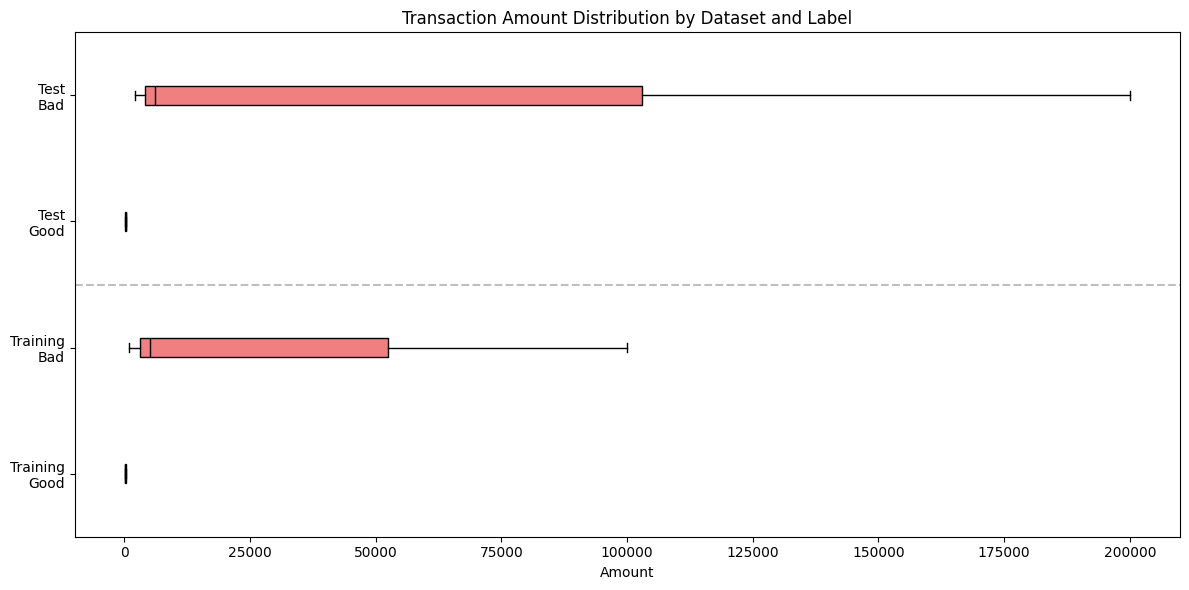

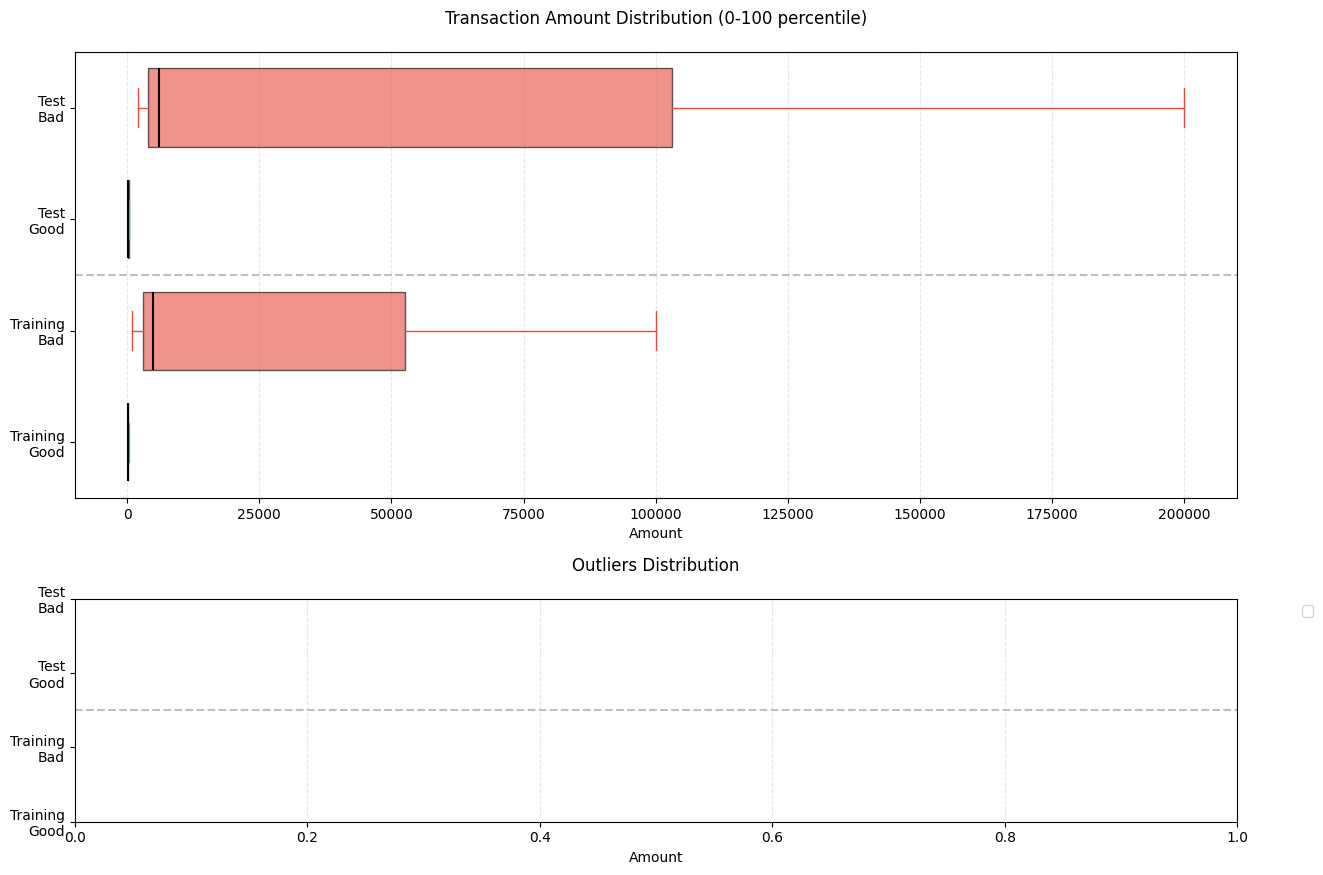

In [4]:
# Test Code:
# Example usage
df1 = pd.DataFrame({
    'amount': [100, 200, 300, 1000, 5000, 100000],
    'label': [0, 0, 0, 1, 1, 1]  # 0 for good, 1 for bad
})

df2 = pd.DataFrame({
    'amount': [150, 250, 350, 2000, 6000, 200000],
    'label': [0, 0, 0, 1, 1, 1]
})

# For regular box plot
fig1, stats1 = plot_amount_distributions(
    df1, df2,
    dataset_names=['Training', 'Test'],
    log_scale=False
)

# For box plot with separate outliers visualization
fig2, stats2 = plot_amount_distributions_with_outliers(
    df1, df2,
    dataset_names=['Training', 'Test'],
    percentile_range=(0,100)
)

# Display statistics
print(stats1)  # or stats2

In [3]:
df1 = pd.read_parquet('../data/jp_morgan/sorted/transaction_metrics_final_aml_v4_cbflag_mod.parquet')
aml_data = df1[['USD_amount', 'Label']].copy()
aml_data.columns = ['amount', 'label']

df2 = pd.read_parquet('../data/jp_morgan/sorted/transaction_metrics_final_ds3_v4_cbflag_mod.parquet')
fraud_data = df2[['USD_amount', 'Label']].copy()
fraud_data.columns = ['amount', 'label']

df3 = pd.read_parquet('../data/jp_morgan/sorted/transaction_metrics_final_fraud_v4_cbflag_mod.parquet')
combined_data = df2[['USD_amount', 'Label']].copy()
combined_data.columns = ['amount', 'label']

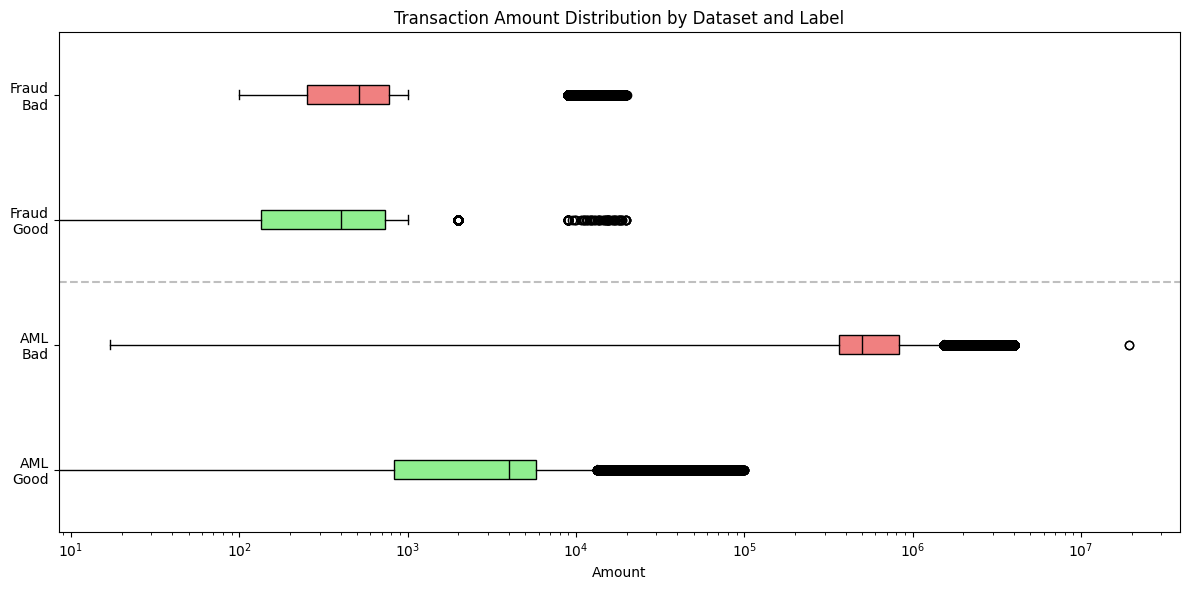

In [6]:
# For regular box plot
fig1, stats1 = plot_amount_distributions(
    aml_data, fraud_data,
    dataset_names=['AML', 'Fraud'],
    log_scale=True
)

# EDA to Figures
# Just exploring the data, summary of data (1-2 lines)

C:\Users\al2-esplana\AppData\Local\Temp\ipykernel_24588\1550686821.py:227: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


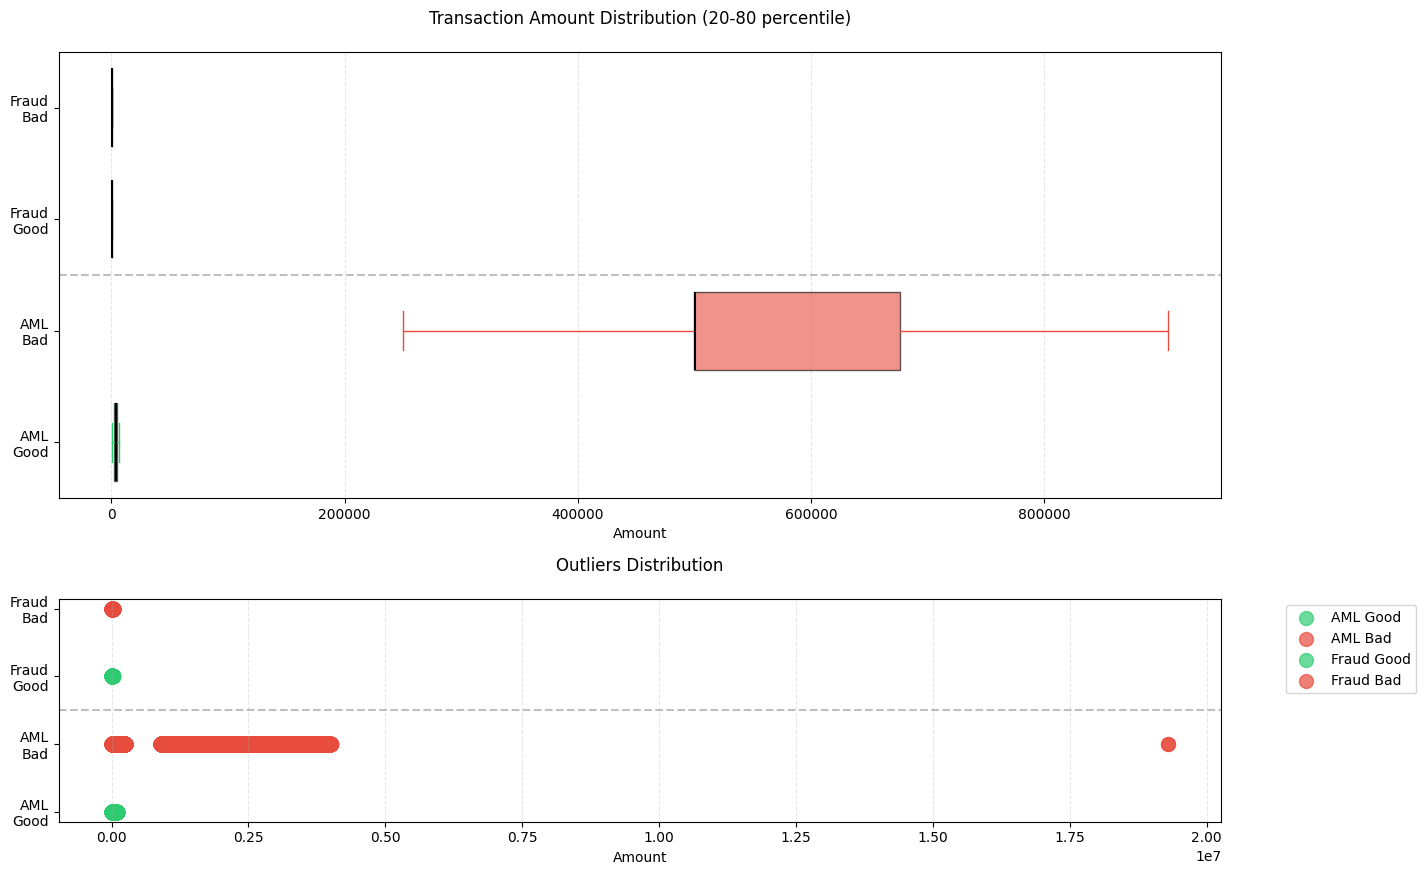

In [7]:
# For box plot with separate outliers visualization
fig2, stats2 = plot_amount_distributions_with_outliers(
    aml_data, fraud_data,
    dataset_names=['AML', 'Fraud'],
    percentile_range=(20,80)
)


In [8]:
print(stats1)

                 Count           Mean     Median            Std    Min  \
Dataset-Label                                                            
AML-Good       1108321    3985.726934    3979.69    3549.537790    0.0   
AML-Bad         282843  688144.471417  500086.00  668522.682488   17.0   
Fraud-Good     1467358     506.455339     401.19     459.143294    0.0   
Fraud-Bad        30819     847.442043     512.23    2003.566402  100.0   

                      25%         75%          Max  Outliers%  
Dataset-Label                                                  
AML-Good          833.190    5818.210     99714.24   0.215641  
AML-Bad        363249.000  829291.000  19300001.00   7.096870  
Fraud-Good        135.530     733.030     19854.49   4.899895  
Fraud-Bad         254.115     773.975     19998.94   3.225283  


In [9]:
print(stats2)

                 Count           Mean     Median            Std    Min  \
Dataset-Label                                                            
AML-Good       1108321    3985.726934    3979.69    3549.537790    0.0   
AML-Bad         282843  688144.471417  500086.00  668522.682488   17.0   
Fraud-Good     1467358     506.455339     401.19     459.143294    0.0   
Fraud-Bad        30819     847.442043     512.23    2003.566402  100.0   

                      25%         75%          Max  Outliers%  
Dataset-Label                                                  
AML-Good          833.190    5818.210     99714.24  39.999874  
AML-Bad        363249.000  829291.000  19300001.00  39.995687  
Fraud-Good        135.530     733.030     19854.49  39.999646  
Fraud-Bad         254.115     773.975     19998.94  40.001298  


In [10]:
df1.columns

Index(['Time_step', 'Label', 'Transaction_Id', 'Transaction_Type',
       'std_txn_type', 'std_txn_method', 'is_credit', 'USD_amount', 'party_Id',
       'party_Account', 'party_Country', 'cparty_Id', 'cparty_Account',
       'cparty_Country', 'txn_time_hr', 'txn_time_mm', 'txn_age_days',
       'prev_std_txn_type', 'prev_std_txn_method', 'prev_is_credit',
       'prev_USD_amount', 'prev_age_delta', 'volume_7d_avg', 'volume_7d_count',
       'volume_14d_avg', 'volume_14d_count', 'volume_30d_avg',
       'volume_30d_count', 'volume_avg_7d_to_14d_ratio',
       'volume_count_7d_to_14d_ratio', 'volume_avg_7d_to_30d_ratio',
       'volume_count_7d_to_30d_ratio', 'volume_avg_14d_to_30d_ratio',
       'volume_count_14d_to_30d_ratio', 'stat_7d_velocity',
       'stat_14d_velocity', 'stat_30d_velocity'],
      dtype='object')

In [11]:
df1 # AML
df = df1.copy()

In [46]:
def txn_summary_table(df):
    temp_df = df[['Time_step', 'Label']].copy()
    
    total_records = len(temp_df)
    total_susp = len(temp_df[temp_df['Label'] == 1])

    temp_df['Time_step'] = pd.to_datetime(df['Time_step'])
    temp_df['yr_mn'] = temp_df['Time_step'].dt.to_period('M')

    # Summary of label counts per year-month
    summary_df = temp_df.groupby('yr_mn').agg(
        label_0_count=('Label', lambda x: (x == 0).sum()),
        label_1_count=('Label', lambda x: (x == 1).sum()),
    )

    # Fraud rate pct
    summary_df['label_1_pct'] = summary_df['label_1_count'] / (summary_df['label_1_count'] + summary_df['label_0_count'])
    summary_df['label_1_rep_pct'] = summary_df['label_1_count'] / total_susp
    summary_df['label_1_cumpct'] = summary_df['label_1_rep_pct'].cumsum() * 100

    # Total record pct
    summary_df['record_pct'] = (summary_df['label_1_count'] + summary_df['label_0_count']) / total_records
    summary_df['cum_record_pct'] = summary_df['record_pct'].cumsum() * 100
    summary_df.index = summary_df.index.astype(str)

    return summary_df.copy()

aml_txn_summary = txn_summary_table(df1)
fraud_txn_summary = txn_summary_table(df2)
combined_txn_summary = txn_summary_table(df3)

In [65]:
df = df1.copy()

df['Time_step'] = pd.to_datetime(df['Time_step'])
total_records = len(df)
total_susp = len(df[df['Label'] == 1])

temp_df = df.groupby('party_Id').agg(
    Time_step=('Time_step', 'min'),
    label_0_count=('Label', lambda x: (x == 0).sum()),
    label_0_amount=('USD_amount', lambda x: x[df['Label'] == 0].sum()),
    label_1_count=('Label', lambda x: (x == 1).sum()),
    label_1_amount=('USD_amount', lambda x: x[df['Label'] == 1].sum()),
    total_count=('Label', 'count'),
    total_volume=('USD_amount', 'sum')
).reset_index().sort_values('Time_step')

# Fraud rate pct
temp_df['label_1_pct'] = temp_df['label_1_count'] / (temp_df['label_1_count'] + temp_df['label_0_count'])
temp_df['label_1_rep_pct'] = temp_df['label_1_count'] / total_susp
temp_df['label_1_cumpct'] = temp_df['label_1_rep_pct'].cumsum() * 100

# Total record pct
temp_df['record_pct'] = (temp_df['label_1_count'] + temp_df['label_0_count']) / total_records
temp_df['cum_record_pct'] = temp_df['record_pct'].cumsum() * 100

In [66]:
temp_df['dt'] = temp_df['Time_step'].dt.to_period('D')
summary_df_aml = temp_df.groupby('dt').agg(
    label_0_count=('label_0_count', 'sum'),
    label_0_amount=('label_0_amount', 'sum'),
    label_1_count=('label_1_count', 'sum'),
    label_1_amount=('label_1_amount', 'sum'),
    total_count=('total_count', 'sum'),
    total_volume=('total_volume', 'sum')
).reset_index()


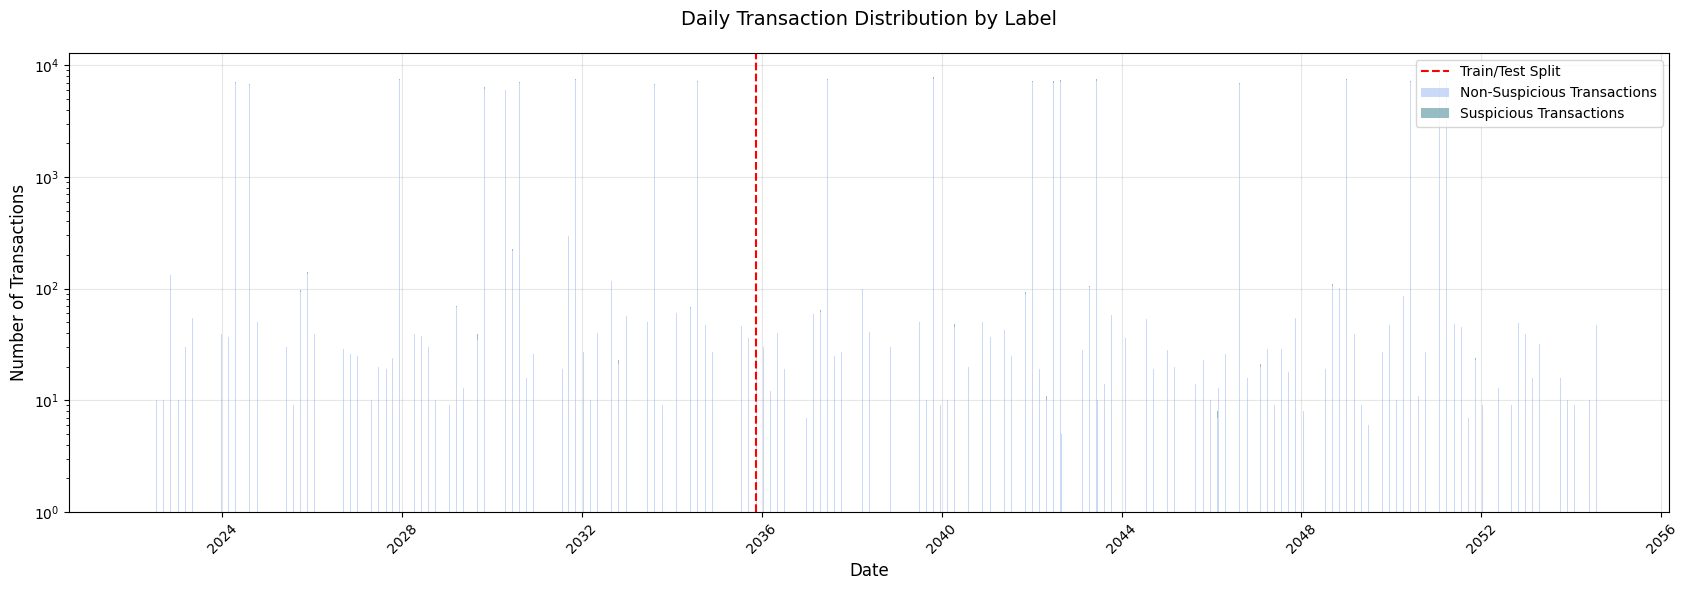

In [63]:
temp_df['dt'] = temp_df['Time_step'].dt.to_period('D')
summary_df = temp_df.groupby('dt').agg(
    label_0_count=('label_0_count', 'sum'),
    label_0_amount=('label_0_amount', 'sum'),
    label_1_count=('label_1_count', 'sum'),
    label_1_amount=('label_1_amount', 'sum'),
    total_count=('total_count', 'sum'),
    total_volume=('total_volume', 'sum')
).reset_index()

def plot(df):
    # Create the visualization
    df['dt'] = df['dt'].dt.to_timestamp()
    fig = plt.figure(figsize=(17, 6))

    # Create stacked bar chart
    plt.bar(df['dt'], df['label_0_count'], 
            label='Non-Suspicious Transactions', 
            color='#B2CAF5', alpha=0.7)
    plt.bar(df['dt'], df['label_1_count'], 
            bottom=df['label_0_count'], 
            label='Suspicious Transactions', 
            color='#6BA0AC', alpha=0.7)

    # Add cutoff line
    cutoff_date = pd.to_datetime('2035-11-11 01:15:26')
    plt.axvline(x=cutoff_date, color='red', linestyle='--', 
                label='Train/Test Split')

    # Customize plot
    plt.title('Daily Transaction Distribution by Label', 
            fontsize=14, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Transactions', fontsize=12)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Calculate and add summary statistics as text
    train_data = df[df['dt'] <= cutoff_date]
    test_data = df[df['dt'] > cutoff_date]

    # stats_text = (
    #     f'Training Set (Before {cutoff_date.strftime("%Y-%m-%d")}):\n'
    #     f'Total Transactions: {train_data["total_count"].sum():,.0f}\n'
    #     f'Suspicious: {train_data["label_1_count"].sum():,.0f} '
    #     f'({100*train_data["label_1_count"].sum()/train_data["total_count"].sum():.1f}%)\n\n'
    #     f'Testing Set:\n'
    #     f'Total Transactions: {test_data["total_count"].sum():,.0f}\n'
    #     f'Suspicious: {test_data["label_1_count"].sum():,.0f} '
    #     f'({100*test_data["label_1_count"].sum()/test_data["total_count"].sum():.1f}%)'
    # )

    # plt.figtext(0.02, 0.02, stats_text, 
    #             fontsize=10, va='bottom', 
    #             bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()
    fig.savefig('../data/split/frd_daily_transaction_distribution.png', dpi=300, transparent=True)

plot(summary_df)

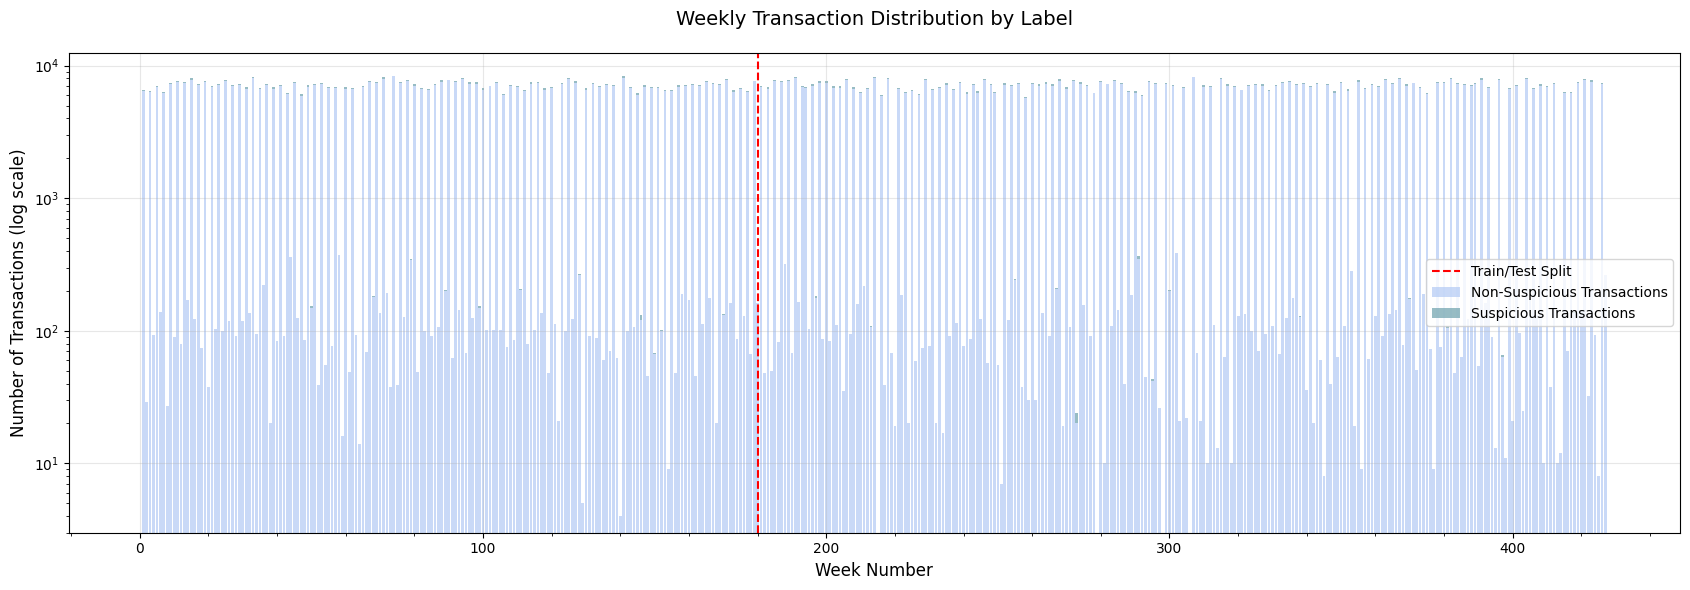

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, AutoMinorLocator
import numpy as np

def create_weekly_plot(df, cutoff_date):
    # Convert dt to datetime if it's period
    if isinstance(df['dt'].iloc[0], pd.Period):
        df['dt'] = df['dt'].dt.to_timestamp()
    
    # Create week groups and get relative week numbers
    df['week'] = df['dt'].dt.to_period('W')
    df = df.groupby('week').agg({
        'label_0_count': 'sum',
        'label_1_count': 'sum',
        'total_count': 'sum',
        'total_volume': 'sum'
    }).reset_index()
    
    # Create relative week numbers
    df['week_num'] = range(1, len(df) + 1)
    
    # Find cutoff week number
    cutoff_week = df[df['week'].dt.start_time > pd.Timestamp(cutoff_date)]['week_num'].iloc[0]
    
    # Create the visualization
    fig = plt.figure(figsize=(17, 6))
    
    # Create stacked bar chart
    plt.bar(df['week_num'], df['label_0_count'], 
            label='Non-Suspicious Transactions', 
            color='#B2CAF5', alpha=0.7)
    plt.bar(df['week_num'], df['label_1_count'], 
            bottom=df['label_0_count'], 
            label='Suspicious Transactions', 
            color='#6BA0AC', alpha=0.7)
    
    # Add cutoff line
    plt.axvline(x=cutoff_week, color='red', linestyle='--', 
                label='Train/Test Split')
    
    # Customize plot
    plt.title('Weekly Transaction Distribution by Label', 
            fontsize=14, pad=20)
    plt.xlabel('Week Number', fontsize=12)
    plt.ylabel('Number of Transactions (log scale)', fontsize=12)
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Set automatic x-axis ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    
    plt.tight_layout()
    return fig

fig = create_weekly_plot(summary_df, '2035-11-11 01:15:26')
fig.savefig('../data/split/frd_weekly_transaction_distribution.png', dpi=300, transparent=True)
plt.show()


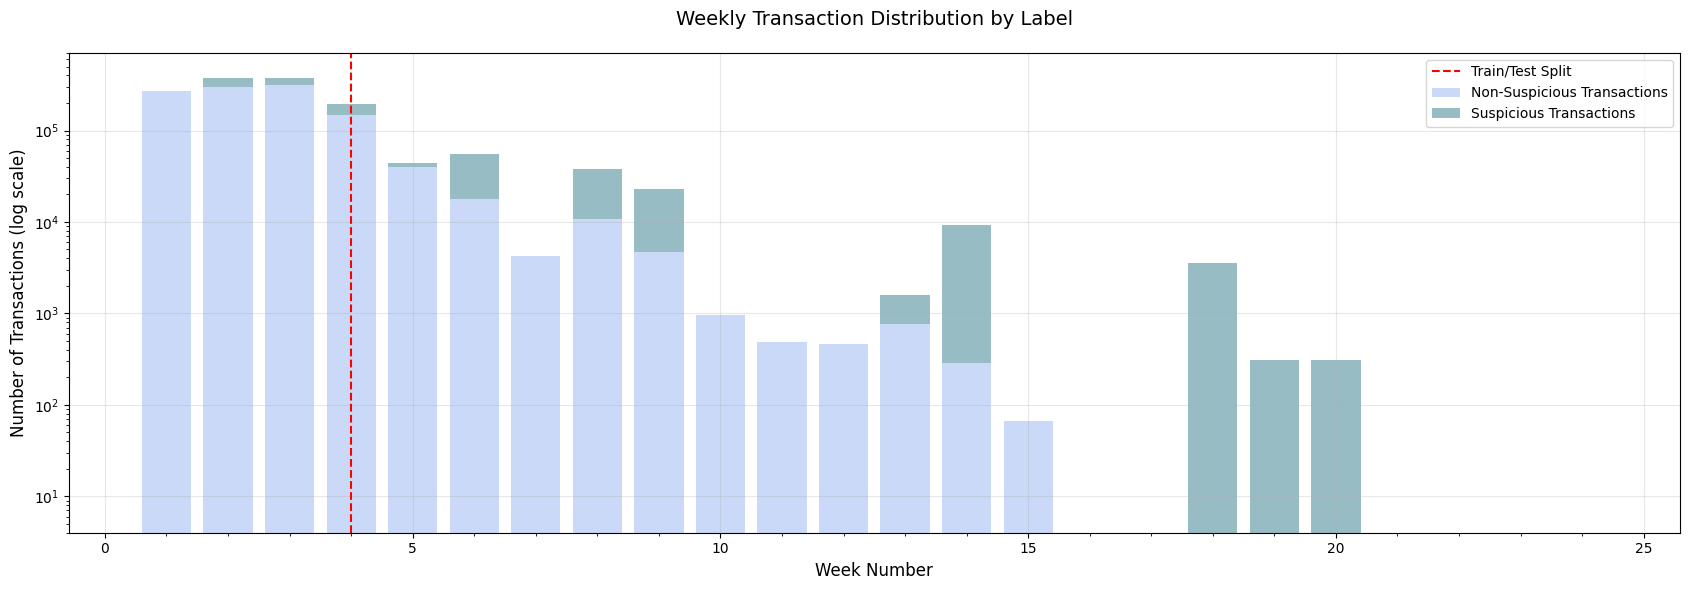

In [71]:
fig2 = create_weekly_plot(summary_df_aml, '2022-02-12 10:50:00')
plt.show()
fig2.savefig('../data/split/aml_weekly_transaction_distribution.png', dpi=300, transparent=True)

In [ ]:
def entity_summary_table(df):
    temp_df = df[['Time_step', 'Label', 'party_Id', 'Transaction_Id', 'USD_amount']].copy()

    total_records = len(temp_df)
    total_susp = len(temp_df[temp_df['Label'] == 1])
    
    temp_df['Time_step'] = pd.to_datetime(temp_df['Time_step'])
    temp_df['txn_date'] = pd.to_datetime(temp_df['Time_step'].dt.date)
    temp_df = temp_df.groupby('party_Id').agg(
        Time_step=('txn_date', 'min'),
        label_0_count=('Label', lambda x: (x == 0).sum()),
        label_0_amount=('USD_amount', lambda x: x[temp_df['Label'] == 0].sum()),
        label_1_count=('Label', lambda x: (x == 1).sum()),
        label_1_amount=('USD_amount', lambda x: x[temp_df['Label'] == 1].sum()),
        total_count=('Label', 'count'),
        total_volume=('USD_amount', 'sum')
    ).reset_index()
    temp_df['yr_mn'] = temp_df['Time_step'].dt.to_period('M')

    summary_df = temp_df.groupby('yr_mn').agg(
        label_0_count=('label_0_count', 'sum'),
        label_0_amount=('label_0_amount', 'sum'),
        label_1_count=('label_1_count', 'sum'),
        label_1_amount=('label_1_amount', 'sum'),
        total_count=('total_count', 'sum'),
        total_volume=('total_volume', 'sum')
    )

    # Fraud rate pct
    summary_df['label_1_pct'] = summary_df['label_1_count'] / (summary_df['label_1_count'] + summary_df['label_0_count'])
    summary_df['label_1_rep_pct'] = summary_df['label_1_count'] / total_susp
    summary_df['label_1_cumpct'] = summary_df['label_1_rep_pct'].cumsum() * 100

    # Total record pct
    summary_df['record_pct'] = (summary_df['label_1_count'] + summary_df['label_0_count']) / total_records
    summary_df['cum_record_pct'] = summary_df['record_pct'].cumsum() * 100
    summary_df.index = summary_df.index.astype(str)

    return summary_df.copy()

aml_entity_summary = entity_summary_table(df1)
fraud_entity_summary = entity_summary_table(df2)
combined_entity_summary = entity_summary_table(df3)

In [5]:
def entity_summary_table(df):
    temp_df = df[['Time_step', 'Label', 'party_Id', 'Transaction_Id', 'USD_amount']].copy()

    total_records = len(temp_df)
    total_susp = len(temp_df[temp_df['Label'] == 1])
    
    temp_df['Time_step'] = pd.to_datetime(temp_df['Time_step'])
    temp_df['txn_date'] = pd.to_datetime(temp_df['Time_step'].dt.date)
    temp_df = temp_df.groupby('party_Id').agg(
        Time_step=('txn_date', 'min'),
        label_0_count=('Label', lambda x: (x == 0).sum()),
        label_0_amount=('USD_amount', lambda x: x[temp_df['Label'] == 0].sum()),
        label_1_count=('Label', lambda x: (x == 1).sum()),
        label_1_amount=('USD_amount', lambda x: x[temp_df['Label'] == 1].sum()),
        total_count=('Label', 'count'),
        total_volume=('USD_amount', 'sum')
    ).reset_index()
    temp_df['yr_mn'] = temp_df['Time_step'].dt.to_period('M')

    summary_df = temp_df.groupby('yr_mn').agg(
        label_0_count=('label_0_count', 'sum'),
        label_0_amount=('label_0_amount', 'sum'),
        label_1_count=('label_1_count', 'sum'),
        label_1_amount=('label_1_amount', 'sum'),
        total_count=('total_count', 'sum'),
        total_volume=('total_volume', 'sum')
    )

    # Fraud rate pct
    summary_df['label_1_pct'] = summary_df['label_1_count'] / (summary_df['label_1_count'] + summary_df['label_0_count'])
    summary_df['label_1_rep_pct'] = summary_df['label_1_count'] / total_susp
    summary_df['label_1_cumpct'] = summary_df['label_1_rep_pct'].cumsum() * 100

    # Total record pct
    summary_df['record_pct'] = (summary_df['label_1_count'] + summary_df['label_0_count']) / total_records
    summary_df['cum_record_pct'] = summary_df['record_pct'].cumsum() * 100
    summary_df.index = summary_df.index.astype(str)

    return summary_df.copy()

aml_entity_summary = entity_summary_table(df1)
fraud_entity_summary = entity_summary_table(df2)
combined_entity_summary = entity_summary_table(df3)

In [6]:
def med_entity_summary_table(df):
    temp_df = df[['Time_step', 'Label', 'party_Id', 'Transaction_Id', 'USD_amount']].copy()

    total_records = len(temp_df)
    total_susp = len(temp_df[temp_df['Label'] == 1])
    
    temp_df['Time_step'] = pd.to_datetime(temp_df['Time_step'])
    temp_df['txn_date'] = pd.to_datetime(temp_df['Time_step'].dt.date)
    temp_df = temp_df.groupby('party_Id').agg(
        Time_step=('txn_date', 'median'),
        label_0_count=('Label', lambda x: (x == 0).sum()),
        label_0_amount=('USD_amount', lambda x: x[temp_df['Label'] == 0].sum()),
        label_1_count=('Label', lambda x: (x == 1).sum()),
        label_1_amount=('USD_amount', lambda x: x[temp_df['Label'] == 1].sum()),
        total_count=('Label', 'count'),
        total_volume=('USD_amount', 'sum')
    ).reset_index()
    temp_df['yr_mn'] = temp_df['Time_step'].dt.to_period('M')

    summary_df = temp_df.groupby('yr_mn').agg(
        label_0_count=('label_0_count', 'sum'),
        label_0_amount=('label_0_amount', 'sum'),
        label_1_count=('label_1_count', 'sum'),
        label_1_amount=('label_1_amount', 'sum'),
        total_count=('total_count', 'sum'),
        total_volume=('total_volume', 'sum')
    )

    # Fraud rate pct
    summary_df['label_1_pct'] = summary_df['label_1_count'] / (summary_df['label_1_count'] + summary_df['label_0_count'])
    summary_df['label_1_rep_pct'] = summary_df['label_1_count'] / total_susp
    summary_df['label_1_cumpct'] = summary_df['label_1_rep_pct'].cumsum() * 100

    # Total record pct
    summary_df['record_pct'] = (summary_df['label_1_count'] + summary_df['label_0_count']) / total_records
    summary_df['cum_record_pct'] = summary_df['record_pct'].cumsum() * 100
    summary_df.index = summary_df.index.astype(str)

    return summary_df.copy()

aml_med_entity_summary = med_entity_summary_table(df1)
fraud_med_entity_summary = med_entity_summary_table(df2)
combined_med_entity_summary = med_entity_summary_table(df3)

In [7]:
df1.columns

Index(['Time_step', 'Label', 'Transaction_Id', 'Transaction_Type',
       'std_txn_type', 'std_txn_method', 'is_credit', 'USD_amount', 'party_Id',
       'party_Account', 'party_Country', 'cparty_Id', 'cparty_Account',
       'cparty_Country', 'txn_time_hr', 'txn_time_mm', 'txn_age_days',
       'prev_std_txn_type', 'prev_std_txn_method', 'prev_USD_amount',
       'prev_age_delta', 'volume_7d_sum', 'velocity_7d_count',
       'stat_7d_median', 'stat_7d_mad', 'under_threshold_7d_count',
       'under_threshold_7d_sum', 'volume_14d_sum', 'velocity_14d_count',
       'stat_14d_median', 'stat_14d_mad', 'under_threshold_14d_count',
       'under_threshold_14d_sum', 'volume_30d_sum', 'velocity_30d_count',
       'stat_30d_median', 'stat_30d_mad', 'under_threshold_30d_count',
       'under_threshold_30d_sum', 'is_crossborder'],
      dtype='object')

In [13]:
def EDA_patterns(df, lbl=None):
    temp_df = df[['Label', 'USD_amount', 'txn_time_hr', 'txn_time_mm', 'txn_age_days', 'std_txn_type', 'std_txn_method', 'is_crossborder', 'under_threshold_14d_count']].copy()
    temp_df['age_bin'] = pd.cut(temp_df['txn_age_days'], bins=[0, 30, 90, 180, float('inf')], labels=['<30', '30-90', '90-180', '180+'])

    amt_bins = [0, 1000, 5000, 10000, 25000, 50000, 100000, float('inf')]
    amt_labels = ['$0-1,000', '$1,000-5,000', '$5,000-10,000', '$10,000-25,000', '$25,000-50,000', '$50,000-100,000', '$100,000+']
    temp_df['amount_bin'] = pd.cut(temp_df['USD_amount'], bins=amt_bins, labels=amt_labels)

    # Transaction Type and Method
    txn_type_mtd = temp_df.groupby(['std_txn_type', 'std_txn_method']).agg(
        label_0_count=('Label', lambda x: (x == 0).sum()),
        label_0_amount=('USD_amount', lambda x: x[temp_df['Label'] == 0].sum()),
        label_1_count=('Label', lambda x: (x == 1).sum()),
        label_1_amount=('USD_amount', lambda x: x[temp_df['Label'] == 1].sum()),
        total_count=('Label', 'count'),
        total_volume=('USD_amount', 'sum')
    ).reset_index()

    # Account Age
    entity_age = temp_df.groupby('age_bin').agg(
        label_0_count=('Label', lambda x: (x == 0).sum()),
        label_0_amount=('USD_amount', lambda x: x[temp_df['Label'] == 0].sum()),
        label_1_count=('Label', lambda x: (x == 1).sum()),
        label_1_amount=('USD_amount', lambda x: x[temp_df['Label'] == 1].sum()),
        total_count=('Label', 'count'),
        total_volume=('USD_amount', 'sum')
    ).reset_index()

    # Hourly Pattern
    hr_pttrn = temp_df.groupby('txn_time_hr').agg(
        label_0_count=('Label', lambda x: (x == 0).sum()),
        label_0_amount=('USD_amount', lambda x: x[temp_df['Label'] == 0].sum()),
        label_1_count=('Label', lambda x: (x == 1).sum()),
        label_1_amount=('USD_amount', lambda x: x[temp_df['Label'] == 1].sum()),
        total_count=('Label', 'count'),
        total_volume=('USD_amount', 'sum')
    ).reset_index()

    # Amount
    amt_pttrn = temp_df.groupby('amount_bin').agg(
        label_0_count=('Label', lambda x: (x == 0).sum()),
        label_0_amount=('USD_amount', lambda x: x[temp_df['Label'] == 0].sum()),
        label_1_count=('Label', lambda x: (x == 1).sum()),
        label_1_amount=('USD_amount', lambda x: x[temp_df['Label'] == 1].sum()),
        total_count=('Label', 'count'),
        total_volume=('USD_amount', 'sum')
    ).reset_index()

    # Crossborder
    cb_pttrn = temp_df.groupby('is_crossborder').agg(
        label_0_count=('Label', lambda x: (x == 0).sum()),
        label_0_amount=('USD_amount', lambda x: x[temp_df['Label'] == 0].sum()),
        label_1_count=('Label', lambda x: (x == 1).sum()),
        label_1_amount=('USD_amount', lambda x: x[temp_df['Label'] == 1].sum()),
        total_count=('Label', 'count'),
        total_volume=('USD_amount', 'sum')
    ).reset_index()

    # Under Threshold Pattern
    under_threshold_count_pttrn = temp_df.groupby('under_threshold_14d_count').agg(
        label_0_count=('Label', lambda x: (x == 0).sum()),
        label_0_amount=('USD_amount', lambda x: x[temp_df['Label'] == 0].sum()),
        label_1_count=('Label', lambda x: (x == 1).sum()),
        label_1_amount=('USD_amount', lambda x: x[temp_df['Label'] == 1].sum()),
        total_count=('Label', 'count'),
        total_volume=('USD_amount', 'sum')
    ).reset_index()

    return {'txn_type_mtd': txn_type_mtd, 'entity_age': entity_age, 'hr_pttrn': hr_pttrn, 'amt_pttrn': amt_pttrn, 'cb_pttrn': cb_pttrn, 'under_threshold_pttrn': under_threshold_count_pttrn}

aml_stat = EDA_patterns(df1, 'aml')  # AML
frd_stat = EDA_patterns(df2, 'frd')  # Fraud
cmb_stat = EDA_patterns(df3, 'cmb')  # Combined

C:\Users\al2-esplana\AppData\Local\Temp\ipykernel_31508\875234673.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  entity_age = temp_df.groupby('age_bin').agg(
C:\Users\al2-esplana\AppData\Local\Temp\ipykernel_31508\875234673.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amt_pttrn = temp_df.groupby('amount_bin').agg(
C:\Users\al2-esplana\AppData\Local\Temp\ipykernel_31508\875234673.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and

In [14]:
def save_to_parquet(stat_dict, prefix):
    for key, df in stat_dict.items():
        filename = f"../data/analysis/{prefix}_{key}.parquet"
        df.to_parquet(filename)

# Save AML statistics to Parquet files
save_to_parquet(aml_stat, 'aml')

# Save Fraud statistics to Parquet files
save_to_parquet(frd_stat, 'frd')

# Save Combined statistics to Parquet files
save_to_parquet(cmb_stat, 'cmb')

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl

plt.style.use('default')
mpl.rcParams.update(mpl.rcParamsDefault)

### MODIFY DEFAULT COLOUR PALETTE ###
# Define the blue warm colors
blue_warm_colors = [
    (37/255, 40/255, 79/255),    # Deep Blue
    (178/255, 202/255, 245/255), # Light Blue
    (80/255, 101/255, 167/255),  # Medium Blue
    (111/255, 156/255, 205/255), # Sky Blue
    (67/255, 125/255, 207/255),  # Bright Blue
    (130/255, 143/255, 167/255), # Gray Blue
    (107/255, 160/255, 172/255), # Teal Blue
    (155/255, 144/255, 159/255)  # Muted Purple
]

# Create a custom color palette
def blue_warm_palette(n_colors=8):
    """Returns a Blue Warm palette with n_colors colors"""
    if n_colors > 8:
        raise ValueError("This palette only supports up to 8 colors")
    return blue_warm_colors[:n_colors]

# Set the custom palette as the default for Seaborn
sns.set_palette(sns.color_palette(blue_warm_colors))



def plot_patterns(stats, title_prefix='', location='../data/figures', dpi=300):
    # Transaction Type-Method
    fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)
    tx = stats['txn_type_mtd'].pivot(index='std_txn_type', columns='std_txn_method', 
                                    values='label_1_count')
    sns.heatmap(tx, annot=True, fmt='g', ax=ax)
    plt.tight_layout()
    fig.savefig(f"{location}/{title_prefix.lower().replace(' ', '_')}_txn_type_mtd.png", dpi=dpi, transparent=True)
    
    # Account Age
    fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)
    df = stats['entity_age']
    ax.bar(df['age_bin'], df['label_0_count'], label='Normal')
    ax.bar(df['age_bin'], df['label_1_count'], bottom=df['label_0_count'], label='Suspicious')
    ax.legend()
    ax.set_yscale('log')  # Set y-axis to log scale
    plt.tight_layout()
    fig.savefig(f"{location}/{title_prefix.lower().replace(' ', '_')}_entity_age.png", dpi=dpi, transparent=True)

    # Hourly Pattern (Count)
    fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)
    df = stats['hr_pttrn']
    total = df['label_0_count'] + df['label_1_count']
    normal_pct = (df['label_0_count'] / total) * 100
    suspicious_pct = (df['label_1_count'] / total) * 100

    # Create stacked bar plot
    ax.bar(df['txn_time_hr'], normal_pct, label='Normal')
    ax.bar(df['txn_time_hr'], suspicious_pct, bottom=normal_pct, label='Suspicious')
    # ax.plot(df['txn_time_hr'], df['total_count'], label='Total')
    # ax.plot(df['txn_time_hr'], df['label_0_count'], label='Normal')
    # ax.plot(df['txn_time_hr'], df['label_1_count'], label='Suspicious')
    ax.legend()
    # ax.set_yscale('log')  # Set y-axis to log scale
    plt.xlabel('Hour of the Day')
    plt.tight_layout()
    fig.savefig(f"{location}/{title_prefix.lower().replace(' ', '_')}_hr_pttrn_count.png", dpi=dpi, transparent=True)

    # Hourly Pattern (Volume)
    fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)
    df = stats['hr_pttrn']
    total = df['label_0_amount'] + df['label_1_amount']
    normal_pct = (df['label_0_amount'] / total) * 100
    suspicious_pct = (df['label_1_amount'] / total) * 100

    # Create stacked bar plot
    ax.bar(df['txn_time_hr'], normal_pct, label='Normal')
    ax.bar(df['txn_time_hr'], suspicious_pct, bottom=normal_pct, label='Suspicious')
    # ax.plot(df['txn_time_hr'], df['total_count'], label='Total')
    # ax.plot(df['txn_time_hr'], df['label_0_count'], label='Normal')
    # ax.plot(df['txn_time_hr'], df['label_1_count'], label='Suspicious')
    ax.legend()
    # ax.set_yscale('log')  # Set y-axis to log scale
    plt.xlabel('Hour of the Day')
    plt.tight_layout()
    fig.savefig(f"{location}/{title_prefix.lower().replace(' ', '_')}_hr_pttrn_vol.png", dpi=dpi, transparent=True)

    # Amount Distribution
    fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)
    df = stats['amt_pttrn']
    ax.bar(range(len(df)), df['label_0_count'], label='Normal')
    ax.bar(range(len(df)), df['label_1_count'], bottom=df['label_0_count'], label='Suspicious')
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df['amount_bin'], rotation=45)
    ax.legend()
    ax.set_yscale('log')  # Set y-axis to log scale
    plt.tight_layout()
    fig.savefig(f"{location}/{title_prefix.lower().replace(' ', '_')}_amt_pttrn.png", dpi=dpi, transparent=True)


# Plot for both datasets
plot_patterns(aml_stat, 'AML')
plot_patterns(frd_stat, 'Fraud')
plot_patterns(cmb_stat, 'Combined')

In [65]:
grouped = df1.groupby('party_Id')['Label'].agg(lambda x: set(x)).reset_index()

In [110]:
def plot_graph(df):
    # Create the Plotly graph
    fig = go.Figure()

    # Add bar traces for label_0_count and label_1_count
    fig.add_trace(go.Bar(
        x=df.index,
        y=df['label_0_count'],
        name='Label 0 Count',
        marker_color='mediumseagreen'
    ))

    fig.add_trace(go.Bar(
        x=df.index,
        y=df['label_1_count'],
        name='Label 1 Count',
        marker_color='salmon'
    ))

    # Add line trace for cumulative percentage
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['cum_record_pct'],
        name='Cumulative Percentage',
        mode='lines+markers',
        yaxis='y2',
        line=dict(color='blue')
    ))

        # Add line trace for cumulative percentage
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['label_1_cumpct'],
        name='Cumulative Percentage for Suspicious Rep',
        mode='lines+markers',
        yaxis='y2',
        line=dict(color='teal')
    ))

    # Update layout
    fig.update_layout(
        title='Stacked Bar Chart with Cumulative Percentage',
        xaxis=dict(title='Year-Month'),
        yaxis=dict(title='Count'),
        yaxis2=dict(
            title='Cumulative %',
            overlaying='y',
            side='right',
            range=[0, 100]
        ),
        barmode='stack'
    )

    fig.show()


In [117]:
plot_graph(aml_entity_summary)

In [83]:
def comparative_table_norm(df, col):
    temp_df = df[['Time_step', 'Label'] + [col]].copy()

    total_records = len(temp_df)
    total_norm = len(temp_df[temp_df['Label'] == 0])
    total_susp = len(temp_df[temp_df['Label'] == 1])


    temp_df = temp_df.groupby(col).agg(
            label_0_count=('Label', lambda x: (x == 0).sum()),
            label_1_count=('Label', lambda x: (x == 1).sum()),
        ).reset_index()

    temp_df['fraud_rate'] = temp_df['label_1_count'] / total_susp
    temp_df['norm_rate'] = temp_df['label_0_count'] / total_norm
    temp_df['risk_mult'] = temp_df['fraud_rate'] / temp_df['norm_rate']
    
    return temp_df.copy()

aml_comp_tbl_hr = comparative_table_norm(df1, 'txn_time_hr')
aml_comp_tbl_txn_type = comparative_table_norm(df1, 'std_txn_type')
aml_comp_tbl_txn_mthd = comparative_table_norm(df1, 'std_txn_method')
frd_comp_tbl_hr = comparative_table_norm(df2, 'txn_time_hr')
frd_comp_tbl_txn_type = comparative_table_norm(df2, 'std_txn_type')
frd_comp_tbl_txn_mthd = comparative_table_norm(df2, 'std_txn_method')


In [85]:
def comparative_table_norm_acct_age(df, col = 'txn_age_days'):
    temp_df = df[['Time_step', 'Label'] + [col]].copy()

    total_records = len(temp_df)
    total_norm = len(temp_df[temp_df['Label'] == 0])
    total_susp = len(temp_df[temp_df['Label'] == 1])
    temp_df[col] = np.ceil(temp_df[col])


    temp_df = temp_df.groupby(col).agg(
            label_0_count=('Label', lambda x: (x == 0).sum()),
            label_1_count=('Label', lambda x: (x == 1).sum()),
        ).reset_index()

    temp_df['fraud_rate'] = temp_df['label_1_count'] / total_susp
    temp_df['norm_rate'] = temp_df['label_0_count'] / total_norm
    temp_df['risk_mult'] = temp_df['fraud_rate'] / temp_df['norm_rate']
    
    return temp_df.copy()

aml_comp_tbl_entity_age = comparative_table_norm_acct_age(df1)
frd_comp_tbl_entity_age = comparative_table_norm_acct_age(df2)


In [95]:
temp_df = df2.copy()
temp_df

,Time_step,Label,Transaction_Id,Transaction_Type,std_txn_type,std_txn_method,is_credit,USD_amount,party_Id,party_Account,...,volume_30d_count,volume_avg_7d_to_14d_ratio,volume_count_7d_to_14d_ratio,volume_avg_7d_to_30d_ratio,volume_count_7d_to_30d_ratio,volume_avg_14d_to_30d_ratio,volume_count_14d_to_30d_ratio,stat_7d_velocity,stat_14d_velocity,stat_30d_velocity
0,2022-03-15 10:24:00,0,EXCHANGE-10115,WITHDRAWAL-EXCHANGE,WITHDRAWAL,CHECK,False,558.43,JPMC-CLIENT-10098,ACCOUNT-10108,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-03-15 10:24:00,0,QUICK-PAYMENT-10116,QUICK-PAYMENT-QUICK-PAYMENT,PAYMENT,ELECTRONIC,False,622.78,JPMC-CLIENT-10098,ACCOUNT-10109,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2022-03-15 10:24:00,0,QUICK-PAYMENT-1110,QUICK-PAYMENT-QUICK-PAYMENT,PAYMENT,ELECTRONIC,False,788.61,JPMC-CLIENT-1093,ACCOUNT-1104,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2022-03-15 10:24:00,0,MAKE-PAYMENT-1113,MAKE-PAYMENT-MAKE-PAYMENT,PAYMENT,ELECTRONIC,True,100.47,JPMC-CLIENT-1093,ACCOUNT-1103,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2022-03-15 10:24:00,0,CASH-CHECK-1399,EXCHANGE-CASH-CHECK,WITHDRAWAL,CHECK,False,663.68,JPMC-CLIENT-1379,ACCOUNT-1390,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498172,2054-09-14 13:17:24,0,PAY-BILL-2180018,MAKE-PAYMENT-PAY-BILL,PAYMENT,ELECTRONIC,False,159.64,JPMC-CLIENT-2179746,ACCOUNT-2179757,...,98,1.030021,1.238095,0.954463,1.137026,0.926643,0.918367,1701.731429,1334.414286,1568.056000
1498173,2054-09-15 00:57:24,0,QUICK-PAYMENT-2181421,QUICK-PAYMENT-QUICK-PAYMENT,PAYMENT,ELECTRONIC,False,120.07,JPMC-CLIENT-2181147,ACCOUNT-2181158,...,96,1.068075,1.086957,1.094857,1.116071,1.025075,1.026786,1791.974286,1543.539286,1466.501000
1498174,2054-09-15 01:17:24,0,PAYMENT-2180021,MAKE-PAYMENT-PAYMENT,PAYMENT,ELECTRONIC,False,25.32,JPMC-CLIENT-2179746,ACCOUNT-2179757,...,96,1.004562,1.209302,0.970625,1.160714,0.966217,0.959821,1728.008571,1422.441429,1533.801333
1498175,2054-09-15 12:57:24,0,QUICK-PAYMENT-2181422,QUICK-PAYMENT-QUICK-PAYMENT,PAYMENT,ELECTRONIC,False,610.91,JPMC-CLIENT-2181147,ACCOUNT-2181158,...,96,1.068075,1.086957,1.094857,1.116071,1.025075,1.026786,1791.974286,1543.539286,1466.501000


In [76]:
col = 'txn_time_hr'
temp_df = df[['Time_step', 'Label'] + [col]].copy()

total_records = len(temp_df)
total_norm = len(temp_df[temp_df['Label'] == 0])
total_susp = len(temp_df[temp_df['Label'] == 1])


temp_df = temp_df.groupby(col).agg(
        label_0_count=('Label', lambda x: (x == 0).sum()),
        label_1_count=('Label', lambda x: (x == 1).sum()),
    ).reset_index()

temp_df['fraud_rate'] = temp_df['label_1_count'] / total_susp
temp_df['norm_rate'] = temp_df['label_0_count'] / total_norm
temp_df['risk_mult'] = temp_df['fraud_rate'] / temp_df['norm_rate']
temp_df

,txn_time_hr,label_0_count,label_1_count,fraud_rate,norm_rate,risk_mult
0,0,47862,12117,0.042840,0.043184,0.992029
1,1,46106,11663,0.041235,0.041600,0.991227
2,2,46177,11706,0.041387,0.041664,0.993351
3,3,45649,11739,0.041504,0.041188,1.007674
4,4,46190,11890,0.042037,0.041676,1.008681
5,5,45538,11816,0.041776,0.041087,1.016756
6,6,46119,11816,0.041776,0.041612,1.003947
7,7,46111,11611,0.041051,0.041604,0.986700
8,8,47647,12368,0.043727,0.042990,1.017148
9,9,45939,11664,0.041238,0.041449,0.994915


In [96]:
# Time of Day Plot
temp_df['txn_date'] = pd.to_datetime(pd.to_datetime(temp_df['Time_step']).dt.date)
temp_df.groupby('party_Id').agg(
    txn_dt_agg=('txn_date', 'median')
)

,txn_dt_agg
party_Id,
JPMC-CLIENT-1000184,2037-01-13 12:00:00
JPMC-CLIENT-1000185,2037-01-16 12:00:00
JPMC-CLIENT-1000463,2037-01-17 12:00:00
JPMC-CLIENT-1000465,2037-01-21 00:00:00
JPMC-CLIENT-1000741,2037-01-14 00:00:00
...,...
JPMC-CLIENT-999374,2037-01-08 00:00:00
JPMC-CLIENT-999375,2037-01-04 00:00:00
JPMC-CLIENT-999586,2036-12-25 12:00:00


In [31]:
df1['velocity_7d_count'].describe()

count    1.391164e+06
mean     6.053607e-01
std      6.412800e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      6.000000e+00
Name: velocity_7d_count, dtype: float64

In [17]:
aml_data.columns

Index(['amount', 'label'], dtype='object')

In [33]:
def calculate_modified_zscore(df, days_list):
    """
    Calculate modified z-score based on given conditions for multiple day periods
    
    Args:
        df: pandas DataFrame
        days_list: list of integers representing different day periods
    
    Returns:
        DataFrame with modified z-scores for each period
    """
    for days in days_list:
    # Calculate 75th percentile threshold
        p75 = df[f'velocity_{days}d_count'].quantile(0.75)
        
        # Initialize result series with zeros
        result = pd.Series(0, index=df.index)
        
        # Calculate modified z-score for rows where count > P75
        mask = df[f'velocity_{days}d_count'] > p75
        result[mask] = 0.6745 * (df.loc[mask, 'USD_amount'] - df.loc[mask, f'stat_{days}d_median']) / df.loc[mask, f'stat_{days}d_mad']
        
        # Assign result to new column
        df[f'stat_{days}d_modzscr'] = result
    
    return df

df1_mod = calculate_modified_zscore(df1, [7, 14, 30])
df2_mod = calculate_modified_zscore(df2, [7, 14, 30])
df3_mod = calculate_modified_zscore(df3, [7, 14, 30])

C:\Users\al2-esplana\AppData\Local\Temp\ipykernel_31508\186609256.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 6.32641624e+00 -6.77819363e-01  8.76192363e+04 ... -1.45392222e+00
 -6.73585506e-01 -2.02350000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result[mask] = 0.6745 * (df.loc[mask, 'USD_amount'] - df.loc[mask, f'stat_{days}d_median']) / df.loc[mask, f'stat_{days}d_mad']
C:\Users\al2-esplana\AppData\Local\Temp\ipykernel_31508\186609256.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.81814596 -0.24609787  4.69447475 ... -1.0960625   0.57073077
  0.19741463]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result[mask] = 0.6745 * (df.loc[mask, 'USD_amount'] - df.loc[mask, f'stat_{days}d_median']) / df.loc[mask,

In [34]:
df1_mod.to_parquet('../data/jp_morgan/sorted/transaction_metrics_final_aml_v4_cbflag_mod.parquet')
df2_mod.to_parquet('../data/jp_morgan/sorted/transaction_metrics_final_fraud_v4_cbflag_mod.parquet')
df3_mod.to_parquet('../data/jp_morgan/sorted/transaction_metrics_final_ds3_v4_cbflag_mod.parquet')

In [13]:
df.groupby('party_Id').agg(

,Time_step,Label,Transaction_Id,Transaction_Type,std_txn_type,std_txn_method,is_credit,USD_amount,party_Id,party_Account,...,volume_30d_sum,velocity_30d_count,stat_30d_median,stat_30d_mad,under_threshold_30d_count,under_threshold_30d_sum,is_crossborder,stat_7d_modzscr,stat_14d_modzscr,stat_30d_modzscr
0,2022-01-07 00:02:00,0,T-1718316-04,WIRE,TRANSFER,ELECTRONIC,True,5249.97,JPMC-CLIENT-1718172-04,CHECKING-1718179-04,...,0.00,0,0.000,0.000,0,0.00,0,0.0000,0.0,0.0
1,2022-01-07 00:02:00,0,T-291469-06,WIRE,TRANSFER,ELECTRONIC,False,5224.67,JPMC-CLIENT-291195-06,CHECKING-291203-06,...,0.00,0,0.000,0.000,0,0.00,0,0.0000,0.0,0.0
2,2022-01-07 00:02:00,0,T-379320-02,WIRE,TRANSFER,ELECTRONIC,False,68.35,JPMC-CLIENT-379064-02,CHECKING-379071-02,...,0.00,0,0.000,0.000,0,0.00,0,0.0000,0.0,0.0
3,2022-01-07 00:02:00,0,T-483373-04,WIRE,TRANSFER,ELECTRONIC,True,869.06,JPMC-CLIENT-483216-04,CHECKING-483225-04,...,0.00,0,0.000,0.000,0,0.00,0,0.0000,0.0,0.0
4,2022-01-07 00:02:00,0,T-498146-04,WIRE,TRANSFER,ELECTRONIC,True,2356.79,JPMC-CLIENT-497983-04,CHECKING-497991-04,...,0.00,0,0.000,0.000,0,0.00,0,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391159,2027-11-05 17:55:00,0,T-303364-08,CASH-DEPOSIT,DEPOSIT,CASH,True,9500.93,JPMC-CLIENT-302740-08,CHECKING-302747-08,...,9500.90,1,9500.900,0.000,1,9500.90,0,0.0000,0.0,0.0
1391160,2027-11-06 03:56:00,0,T-303369-08,CASH-DEPOSIT,DEPOSIT,CASH,True,9500.87,JPMC-CLIENT-302740-08,CHECKING-302747-08,...,19001.83,2,9500.915,0.015,2,19001.83,0,-2.0235,0.0,0.0
1391161,2027-12-01 03:18:00,0,T-303347-08,CASH-DEPOSIT,DEPOSIT,CASH,True,9500.28,JPMC-CLIENT-302740-08,CHECKING-302747-08,...,28502.70,3,9500.900,0.030,3,28502.70,0,0.0000,0.0,0.0
1391162,2027-12-02 01:16:00,0,T-981700-10,WITHDRAWL,WITHDRAWAL,CASH,False,5000.64,JPMC-CLIENT-981092-10,CHECKING-981105-10,...,0.00,0,0.000,0.000,0,0.00,0,0.0000,0.0,0.0
